# Campaña "Seguro Vivienda" de compañía financiera

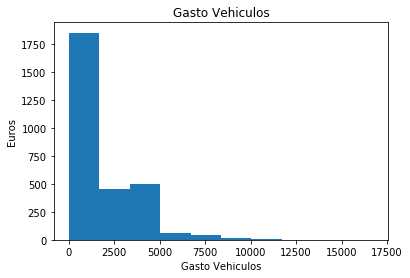

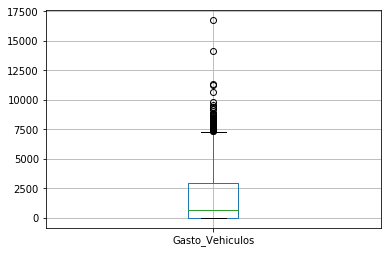

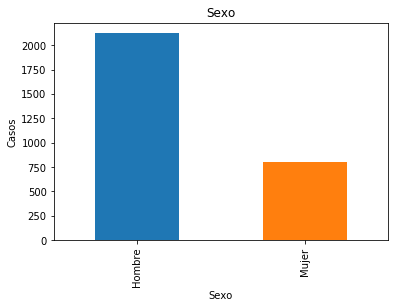

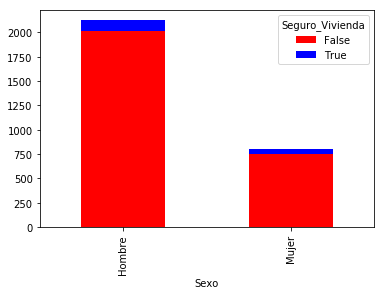

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2926
Data columns (total 28 columns):
ID_Cliente                             2927 non-null object
Fecha_Nacimiento                       2927 non-null object
Fecha_Alta                             2927 non-null object
Sexo                                   2927 non-null object
ID_Zona                                2927 non-null object
Productos_Vida                         2927 non-null int64
Productos_Vehiculos                    2927 non-null int64
Productos_Otros                        2927 non-null int64
Gasto_Vida                             2927 non-null float64
Gasto_Vehiculos                        2927 non-null float64
Gasto_Otros                            2927 non-null float64
Tipo_Familia                           2927 non-null float64
Tipo_Pareja                            2927 non-null float64
Tipo_Soltero                           2927 non-null float64
Educacion_Superior                     2927 non-nu

In [3]:
%run 1-1-Exploracion.ipynb

## Selección de variables

Hay diversos métodos que nos permiten identificar las mejores variables para resolver nuestro problema. Scikit permite identificar las mejores variables según diversos tests estadísticos, aunque debemos utilizar sólo las variables numéricas:

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2 = SelectKBest(chi2, k=10).fit(variables._get_numeric_data(), targets)
for (col, sel) in zip(variables._get_numeric_data().columns.values, chi2.get_support()):
    if sel:
        print(col)
seleccion = chi2.transform(variables._get_numeric_data())

Gasto_Vida
Gasto_Vehiculos
Gasto_Otros
Educacion_Superior
Educacion_Baja
Poblacion_Empresario
Poblacion_Trabajador_No_Cualificado
Vivienda_Propiedad
Vivienda_Alquiler
Medico_Seguro_Privado


Veamos cómo queda representada una muestra del dataset respecto de las dos mejores variables:

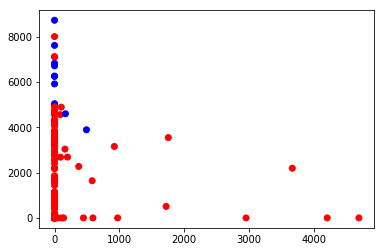

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(seleccion[1:200, 0], seleccion[1:200, 1], c=targets[1:200], cmap=cm_bright)
plt.show()

Se puede ver cómo al representar las muestras respecto de estas dos variables, los casos de clientes que han contratado el producto se distinguen más fácilmente, ya que tienden a tener un valor alto en una de ellas (puntos azules). Por tanto, estas variables parecen ser buenas a la hora de distinguir casos positivos y negativos.

Cuando el proceso de modelización es costoso, el reducir el número de variables puede ser de gran ayuda, pero hay que realizar esta selección de una forma razonable y mediante un proceso formal como este. Las técnicas de selección de variables se usan ampliamente en los procesos de análisis de datos y modelización.

## Transformación de variables

Repite el proceso utilizando PCA en lugar de una técnica de selección de variables y comenta los resultados:


In [27]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=10).fit(variables._get_numeric_data(), targets)
### veamos cuanta varianza explica el modelo:
print("Varianza acumulada explicada por cada componente (tanto por uno): ", pca.explained_variance_ratio_.cumsum())

Varianza acumulada explicada por cada componente (tanto por uno):  [0.86426151 0.98018988 0.99803623 0.99879546 0.99916202 0.99934778
 0.99952203 0.99963271 0.99973099 0.99981113]


He partido de 10 componentes, pero como vemos la primera componente explica el 86% de las variables y con dos componentes el 98%, por tanto quedándonos con dos componentes podemos perfectamente crear un modelo. en el siguiente paso haremos un pca de 2 componentes que será el que utilizaremos más adelante.

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(variables._get_numeric_data(), targets)
### veamos cuanta varianza explica el modelo:
print("Varianza acumulada explicada por cada componente (tanto por uno): ", pca.explained_variance_ratio_.cumsum())

#ahora hacemos un data.frame para ver lo que aporta cada variavble a las componentes
pd.DataFrame(pca.components_.T, index=variables._get_numeric_data().columns.tolist())
#variables._get_numeric_data().columns.shape



Varianza acumulada explicada por cada componente (tanto por uno):  [0.86426151 0.98018988]


,0,1
Productos_Vida,0.000011,0.000023
Productos_Vehiculos,0.000250,0.000090
Productos_Otros,0.000077,0.000488
Gasto_Vida,0.003076,0.014158
Gasto_Vehiculos,0.998926,-0.046175
Gasto_Otros,0.046110,0.998792
Tipo_Familia,0.000484,0.000060
Tipo_Pareja,0.000096,0.000742
Tipo_Soltero,-0.000580,-0.000802
Educacion_Superior,0.000475,-0.000399


Viendo la tabla superior podemos decir que las variables más importantes son:
* Componente 0: Gasto Vehículos
* Componente 1: Gasto Otros

He probado con 3 componentes y en ese caso la tercera componente sería "Gasto Vida", pero una tercera componente no es necesaria ya que con 2 explicamos un 98% del modelo.

Llegados a este punto nos surge el dilema: PCA o Feature Selection. Podemos tener dos casos principales que nos ayuden a decidir:
* **Necesidad de un modelo interpretativo**: en este caso lo recomendable es el feature selection para poder evaluar el impacto de cada variable independiente (al menos las que tienen mayor impacto) en la variable objetivo. Además existe la posiblidad de construir un modelo simple con tres variables (Gasto Vehículos, Gasto Otros, Gasto Vida) que debería explicar el modelo razonablemente bien, ya que las tres variables (en el PCA) tiene una aportación individual próxima a 1 (siendo el valor del resto de variables próximo a 0) en las tres primeras componentes (se puede ejecutar el código anterior para 3 componentes y comprobar esto)

* **Necesidad de agilidad y buena precisión**: podemos usar el modelo con PCA con 2 componentes, perdemos interpretabilidad, pero para gran cantidad de datos sería conveniente ya que reduciríamos el número de variables que entraría al modelo, incluso se pueden usar 3 componentes y casi explicaríamos el 100%. Por otro lado en este caso perderíamos también interacciones entre variables, aunque viendo la explicabilidad de las componentes no preocupa.

L

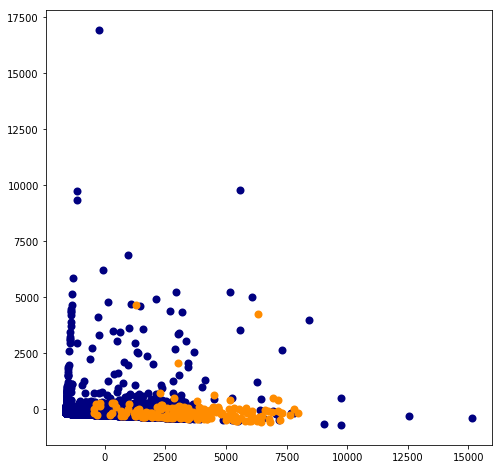

In [66]:
X_pca = pca.fit_transform(variables._get_numeric_data())
y=targets
colors = ['navy',  'darkorange']
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0, 1], targets):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
                color=color, lw=2, label=target_name)

plt.show()



## Objetivo

El objetivo de este apartado es que aprendas a seleccionar variables o a crear variables sintéticas, y que entiendas las ventajas de hacerlo. ¿Podrías probar varias técnicas de selección y transformación de variables? Ten en cuenta que no sólo es importante lo buenas que sean las variables finales para la predicción, sino también que el coste de calcularlas sea razonable y que seas capaz de explicar y justificar estas variables en caso de que el cliente lo solicite.

## Referencias

* http://scikit-learn.org/stable/modules/feature_selection.html
* http://scikit-learn.org/stable/modules/decomposition.html